In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not available, installing...")
    !pip install lightgbm -q
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


---
## Load  Data

In [19]:
# Load the model-ready dataset
df = pd.read_csv('../data/model_ready_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nCrops: {df['item'].unique().tolist()}")
print(f"Markets: {df['market'].nunique()} unique markets")

Dataset Shape: 109,200 rows × 23 columns
Date Range: 2020-01-08 to 2024-12-31

Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']
Markets: 15 unique markets


Volume Statistics (MT) by Crop:
            Mean    Std  Min     Max  Median
item                                        
Beetroot    5.89   1.60  1.0   14.28    5.85
Raddish     6.14   1.66  1.0   13.46    6.09
Red Onion   6.18   1.65  1.0   13.24    6.13
Rice       48.74  13.18  1.0  107.10   48.28


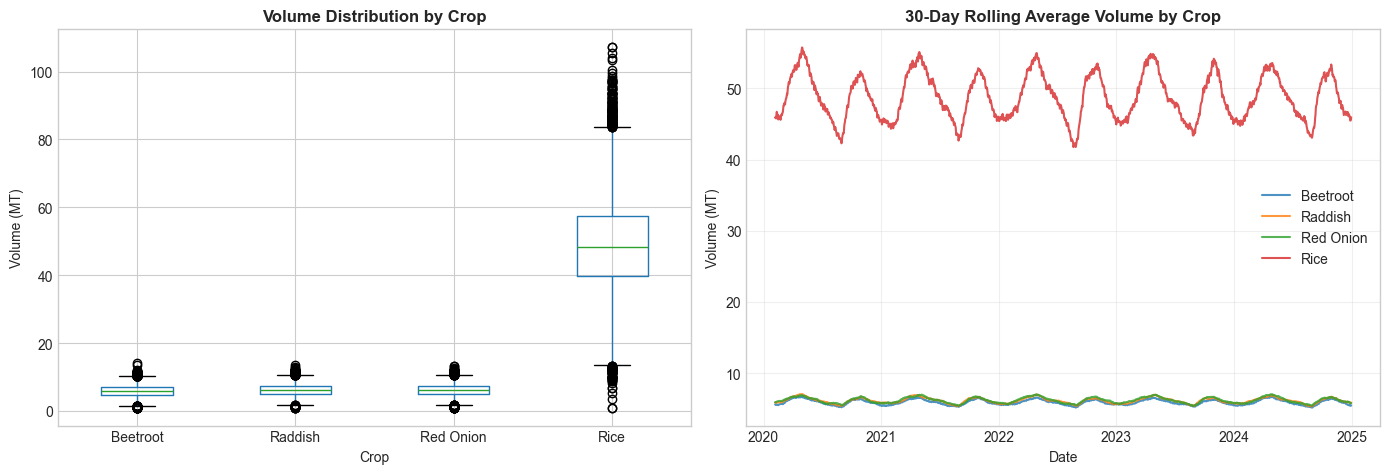

In [20]:
# Analyze volume distribution
print("Volume Statistics (MT) by Crop:")
volume_stats = df.groupby('item')['volume_MT'].agg(['mean', 'std', 'min', 'max', 'median'])
volume_stats.columns = ['Mean', 'Std', 'Min', 'Max', 'Median']
print(volume_stats.round(2))

# Visualize volume distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot by crop
ax1 = axes[0]
df.boxplot(column='volume_MT', by='item', ax=ax1)
ax1.set_title('Volume Distribution by Crop', fontsize=12, fontweight='bold')
ax1.set_xlabel('Crop')
ax1.set_ylabel('Volume (MT)')
plt.suptitle('')

# Time series of average daily volume
ax2 = axes[1]
daily_volume = df.groupby(['Date', 'item'])['volume_MT'].mean().reset_index()
for crop in df['item'].unique():
    crop_data = daily_volume[daily_volume['item'] == crop]
    ax2.plot(crop_data['Date'], crop_data['volume_MT'].rolling(30).mean(), 
             label=crop, alpha=0.8, linewidth=1.5)
ax2.set_title('30-Day Rolling Average Volume by Crop', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume (MT)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Define Forecast Horizons

In [21]:
# Define forecast horizons (in days)
HORIZONS = {
    '1_week': 7,
    '2_weeks': 14,
    '4_weeks': 28,
    '8_weeks': 56,
    '12_weeks': 84
}

print("Demand Forecast Horizons:")
for name, days in HORIZONS.items():
    print(f"  • {name}: {days} days ahead")

Demand Forecast Horizons:
  • 1_week: 7 days ahead
  • 2_weeks: 14 days ahead
  • 4_weeks: 28 days ahead
  • 8_weeks: 56 days ahead
  • 12_weeks: 84 days ahead


---
## Data Preparation

In [22]:
# Aggregate data by Date and Crop (average across all markets)
# Add time features
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

agg_df = df.groupby(['Date', 'item']).agg({
    'price': 'mean',
    'volume_MT': 'mean',
    'temperature_avg_C': 'mean',
    'rainfall_mm': 'mean',
    'humidity_percent': 'mean',
    'month': 'first',
    'day_of_week': 'first',
    'quarter': 'first',
    'week_of_year': 'first',
    'is_public_holiday': 'max',
    'is_day_before_holiday': 'max',
    'near_major_holiday': 'max',
    'demand_multiplier': 'mean',
    'harvest_period_rice': 'max',
    'vegetable_peak_season': 'max'
}).reset_index()

agg_df = agg_df.sort_values(['item', 'Date']).reset_index(drop=True)

print(f"Aggregated data shape: {agg_df.shape}")
print(f"\nRecords per crop:")
print(agg_df.groupby('item').size())

Aggregated data shape: (7280, 17)

Records per crop:
item
Beetroot     1820
Raddish      1820
Red Onion    1820
Rice         1820
dtype: int64


In [23]:
def create_volume_targets(df, target_col='volume_MT', horizons=HORIZONS):
    """
    Create future volume target columns for each horizon.
    """
    df = df.copy()
    
    for horizon_name, days in horizons.items():
        # Shift volume backwards (so current row has future volume as target)
        df[f'volume_target_{horizon_name}'] = df.groupby('item')[target_col].shift(-days)
    
    return df

# Create volume targets
agg_df = create_volume_targets(agg_df)

# Check target columns
target_cols = [col for col in agg_df.columns if col.startswith('volume_target_')]
print("Volume target columns created:")
for col in target_cols:
    non_null = agg_df[col].notna().sum()
    print(f"  • {col}: {non_null:,} valid samples")

Volume target columns created:
  • volume_target_1_week: 7,252 valid samples
  • volume_target_2_weeks: 7,224 valid samples
  • volume_target_4_weeks: 7,168 valid samples
  • volume_target_8_weeks: 7,056 valid samples
  • volume_target_12_weeks: 6,944 valid samples


In [24]:
def add_demand_features(df):
    """
    Add lag features and rolling statistics for volume prediction.
    """
    df = df.copy()
    
    # Volume lag features
    for lag in [1, 7, 14, 28]:
        df[f'volume_lag_{lag}'] = df.groupby('item')['volume_MT'].shift(lag)
    
    # Price lag features (price affects demand)
    for lag in [1, 7, 14, 28]:
        df[f'price_lag_{lag}'] = df.groupby('item')['price'].shift(lag)
    
    # Volume rolling statistics
    df['volume_rolling_7_mean'] = df.groupby('item')['volume_MT'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['volume_rolling_7_std'] = df.groupby('item')['volume_MT'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    df['volume_rolling_28_mean'] = df.groupby('item')['volume_MT'].transform(
        lambda x: x.rolling(window=28, min_periods=1).mean()
    )
    
    # Price rolling statistics
    df['price_rolling_7_mean'] = df.groupby('item')['price'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    
    # Volume momentum
    df['volume_momentum_7'] = df['volume_MT'] - df['volume_lag_7']
    df['volume_momentum_28'] = df['volume_MT'] - df['volume_lag_28']
    
    # Price-Volume relationship (price elasticity proxy)
    df['price_change_7'] = (df['price'] - df['price_lag_7']) / df['price_lag_7'].replace(0, np.nan)
    
    return df

agg_df = add_demand_features(agg_df)
print(f"Features added. Total columns: {len(agg_df.columns)}")
print(f"\nNew feature columns:")
new_cols = [col for col in agg_df.columns if 'lag' in col or 'rolling' in col or 'momentum' in col]
print(new_cols)

Features added. Total columns: 37

New feature columns:
['volume_lag_1', 'volume_lag_7', 'volume_lag_14', 'volume_lag_28', 'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_lag_28', 'volume_rolling_7_mean', 'volume_rolling_7_std', 'volume_rolling_28_mean', 'price_rolling_7_mean', 'volume_momentum_7', 'volume_momentum_28']


---
## Baseline Model: Seasonal Naïve

In [25]:
# Seasonal Naive baseline for volume
baseline_results = {}

print("Seasonal Naïve Baseline Results (Volume):")
print("="*50)

for horizon_name, days in HORIZONS.items():
    target_col = f'volume_target_{horizon_name}'
    
    # Use current volume as naive prediction
    y_true = agg_df[target_col].dropna()
    y_pred_naive = agg_df['volume_MT'].loc[y_true.index]
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred_naive)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_naive))
    mape = np.mean(np.abs((y_true - y_pred_naive) / y_true.replace(0, np.nan))) * 100
    
    baseline_results[horizon_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    print(f"\n{horizon_name} ({days} days):")
    print(f"  MAE:  {mae:.4f} MT")
    print(f"  RMSE: {rmse:.4f} MT")
    print(f"  MAPE: {mape:.2f}%")

Seasonal Naïve Baseline Results (Volume):

1_week (7 days):
  MAE:  1.3150 MT
  RMSE: 2.4697 MT
  MAPE: 7.98%

2_weeks (14 days):
  MAE:  1.3957 MT
  RMSE: 2.6222 MT
  MAPE: 8.42%

4_weeks (28 days):
  MAE:  1.5629 MT
  RMSE: 2.9381 MT
  MAPE: 9.42%

8_weeks (56 days):
  MAE:  2.0054 MT
  RMSE: 3.6803 MT
  MAPE: 11.99%

12_weeks (84 days):
  MAE:  2.2042 MT
  RMSE: 3.9498 MT
  MAPE: 13.15%

1_week (7 days):
  MAE:  1.3150 MT
  RMSE: 2.4697 MT
  MAPE: 7.98%

2_weeks (14 days):
  MAE:  1.3957 MT
  RMSE: 2.6222 MT
  MAPE: 8.42%

4_weeks (28 days):
  MAE:  1.5629 MT
  RMSE: 2.9381 MT
  MAPE: 9.42%

8_weeks (56 days):
  MAE:  2.0054 MT
  RMSE: 3.6803 MT
  MAPE: 11.99%

12_weeks (84 days):
  MAE:  2.2042 MT
  RMSE: 3.9498 MT
  MAPE: 13.15%


---
## LightGBM Demand Forecasting

In [26]:
# Prepare feature columns for demand forecasting
feature_cols = [
    # Current values
    'price', 'volume_MT',
    
    # Weather
    'temperature_avg_C', 'rainfall_mm', 'humidity_percent',
    
    # Time features
    'month', 'day_of_week', 'quarter', 'week_of_year',
    
    # Seasonal/Holiday features
    'is_public_holiday', 'is_day_before_holiday', 'near_major_holiday',
    'demand_multiplier', 'harvest_period_rice', 'vegetable_peak_season',
    
    # Volume lag features
    'volume_lag_1', 'volume_lag_7', 'volume_lag_14', 'volume_lag_28',
    
    # Price lag features
    'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_lag_28',
    
    # Rolling statistics
    'volume_rolling_7_mean', 'volume_rolling_7_std', 'volume_rolling_28_mean',
    'price_rolling_7_mean',
    
    # Momentum
    'volume_momentum_7', 'volume_momentum_28',
    
    # Price change
    'price_change_7'
]

# Add item encoding
le_item = LabelEncoder()
agg_df['item_encoded'] = le_item.fit_transform(agg_df['item'])
feature_cols.append('item_encoded')

# Check available features
available_features = [col for col in feature_cols if col in agg_df.columns]
print(f"Features available: {len(available_features)}/{len(feature_cols)}")

missing = set(feature_cols) - set(available_features)
if missing:
    print(f"Missing features: {missing}")

Features available: 31/31


In [27]:
# Train LightGBM model for each horizon
lgb_models = {}
lgb_results = {}

# Prepare clean dataset
df_clean = agg_df.dropna(subset=available_features).copy()
print(f"Clean dataset: {len(df_clean):,} rows")

for horizon_name, days in HORIZONS.items():
    target_col = f'volume_target_{horizon_name}'
    
    # Drop rows where target is NaN
    df_horizon = df_clean.dropna(subset=[target_col]).copy()
    
    if len(df_horizon) < 100:
        print(f"\n{horizon_name}: Insufficient data, skipping...")
        continue
    
    # Prepare X and y
    X = df_horizon[available_features]
    y = df_horizon[target_col]
    
    # Time-based split (80% train, 20% test)
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42
    }
    
    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100
    
    lgb_models[horizon_name] = model
    lgb_results[horizon_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'y_test': y_test.values,
        'y_pred': y_pred,
        'n_samples': len(y_test)
    }
    
    print(f"\n{horizon_name} ({days} days ahead):")
    print(f"  Samples: {len(y_train):,} train, {len(y_test):,} test")
    print(f"  MAE:  {mae:.4f} MT")
    print(f"  RMSE: {rmse:.4f} MT")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

Clean dataset: 7,168 rows

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's rmse: 3.92083
Early stopping, best iteration is:
[97]	valid_0's rmse: 3.92083

1_week (7 days ahead):
  Samples: 5,712 train, 1,428 test
  MAE:  3.1003 MT
  RMSE: 3.9208 MT
  R²:   0.5516
  MAPE: 6.40%
Training until validation scores don't improve for 50 rounds

1_week (7 days ahead):
  Samples: 5,712 train, 1,428 test
  MAE:  3.1003 MT
  RMSE: 3.9208 MT
  R²:   0.5516
  MAPE: 6.40%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 3.90176

2_weeks (14 days ahead):
  Samples: 5,689 train, 1,423 test
  MAE:  3.0574 MT
  RMSE: 3.9018 MT
  R²:   0.5560
  MAPE: 6.29%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 3.90176

2_weeks (14 days ahead):
  Samples: 5

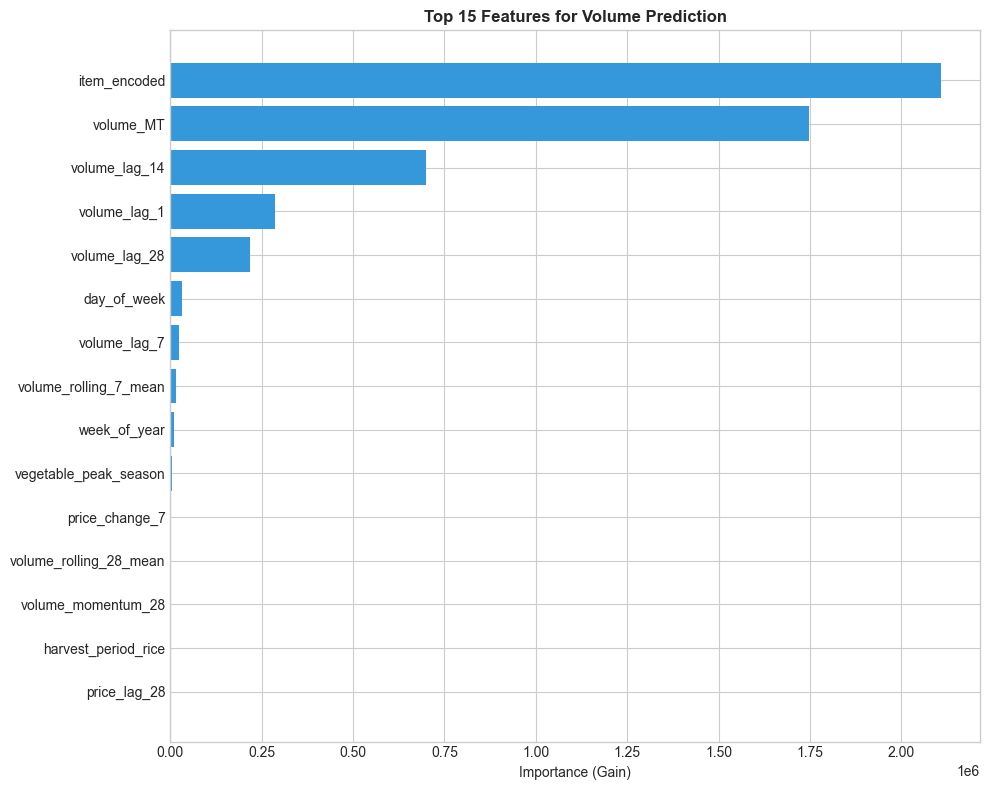

               Feature   Importance
          item_encoded 2.109762e+06
             volume_MT 1.747477e+06
         volume_lag_14 6.986557e+05
          volume_lag_1 2.862404e+05
         volume_lag_28 2.176508e+05
           day_of_week 3.197527e+04
          volume_lag_7 2.464401e+04
 volume_rolling_7_mean 1.532014e+04
          week_of_year 8.691734e+03
 vegetable_peak_season 4.068402e+03
        price_change_7 2.532047e+03
volume_rolling_28_mean 2.366320e+03
    volume_momentum_28 2.143290e+03
   harvest_period_rice 1.990373e+03
          price_lag_28 1.742786e+03


In [28]:
# Feature importance analysis

if '1_week' in lgb_models:
    importance_df = pd.DataFrame({
        'Feature': available_features,
        'Importance': lgb_models['1_week'].feature_importance(importance_type='gain')
    }).sort_values('Importance', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    top_15 = importance_df.head(15)
    ax.barh(top_15['Feature'], top_15['Importance'], color='#3498db')
    ax.set_xlabel('Importance (Gain)')
    ax.set_title('Top 15 Features for Volume Prediction', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(top_15.to_string(index=False))

---
## LSTM Demand Forecasting

In [29]:
def create_sequences_multi_output(data, targets, seq_length=14):
    """
    Create sequences for LSTM with multiple output horizons.
    """
    X_seq, y_seq = [], []
    
    for i in range(len(data) - seq_length):
        if not np.isnan(targets[i + seq_length]).any():
            X_seq.append(data[i:i + seq_length])
            y_seq.append(targets[i + seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# LSTM sequence length
SEQ_LENGTH = 14
print(f"Sequence length: {SEQ_LENGTH} days")

Sequence length: 14 days


In [30]:
# LSTM features for demand forecasting
lstm_features = [
    'price', 'volume_MT', 'temperature_avg_C', 'rainfall_mm', 
    'humidity_percent', 'month', 'day_of_week',
    'is_public_holiday', 'demand_multiplier'
]

volume_target_cols = [f'volume_target_{h}' for h in HORIZONS.keys()]

# Train LSTM for each crop
lstm_models = {}
lstm_results = {}
lstm_scalers_X = {}
lstm_scalers_y = {}

crops = agg_df['item'].unique()

for crop in crops:
    print(f"\n{'='*60}")
    print(f"Training LSTM for: {crop}")
    print('='*60)
    
    # Get crop data
    crop_df = agg_df[agg_df['item'] == crop].copy()
    crop_df = crop_df.sort_values('Date').reset_index(drop=True)
    
    # Drop rows with NaN
    crop_df = crop_df.dropna(subset=lstm_features + volume_target_cols)
    
    if len(crop_df) < 100:
        print(f"  Insufficient data ({len(crop_df)} rows), skipping...")
        continue
    
    print(f"  Data points: {len(crop_df)}")
    
    # Prepare features and targets
    X_crop = crop_df[lstm_features].values
    y_crop = crop_df[volume_target_cols].values
    
    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_crop)
    lstm_scalers_X[crop] = scaler_X
    
    # Scale targets
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_crop)
    lstm_scalers_y[crop] = scaler_y
    
    # Create sequences
    X_seq, y_seq = create_sequences_multi_output(X_scaled, y_scaled, SEQ_LENGTH)
    
    if len(X_seq) < 50:
        print(f"  Insufficient sequences ({len(X_seq)}), skipping...")
        continue
    
    print(f"  Total sequences: {len(X_seq)}")
    
    # Time-based split
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    
    print(f"  Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Build Multi-Output LSTM model
    n_horizons = len(HORIZONS)
    
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), 
                      input_shape=(SEQ_LENGTH, len(lstm_features))),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(n_horizons)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)
    
    # Train
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    print(f"  Epochs trained: {len(history.history['loss'])}")
    
    # Predict
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Inverse transform
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test)
    
    # Store model
    lstm_models[crop] = model
    
    # Calculate metrics for each horizon
    crop_results = {}
    print(f"\n  Results by horizon:")
    
    for i, horizon_name in enumerate(HORIZONS.keys()):
        y_true_h = y_test_original[:, i]
        y_pred_h = y_pred_original[:, i]
        
        mae = mean_absolute_error(y_true_h, y_pred_h)
        rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
        r2 = r2_score(y_true_h, y_pred_h)
        
        crop_results[horizon_name] = {
            'MAE': mae, 'RMSE': rmse, 'R2': r2,
            'y_test': y_true_h, 'y_pred': y_pred_h
        }
        
        print(f"    {horizon_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")
    
    lstm_results[crop] = crop_results


Training LSTM for: Beetroot
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345
  Epochs trained: 34
  Epochs trained: 34

  Results by horizon:
    1_week: MAE=0.3810, RMSE=0.4915, R²=0.5340
    2_weeks: MAE=0.3719, RMSE=0.4764, R²=0.5607
    4_weeks: MAE=0.3957, RMSE=0.4995, R²=0.5286
    8_weeks: MAE=0.3639, RMSE=0.4689, R²=0.5782
    12_weeks: MAE=0.3685, RMSE=0.4654, R²=0.5893

Training LSTM for: Raddish
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345

  Results by horizon:
    1_week: MAE=0.3810, RMSE=0.4915, R²=0.5340
    2_weeks: MAE=0.3719, RMSE=0.4764, R²=0.5607
    4_weeks: MAE=0.3957, RMSE=0.4995, R²=0.5286
    8_weeks: MAE=0.3639, RMSE=0.4689, R²=0.5782
    12_weeks: MAE=0.3685, RMSE=0.4654, R²=0.5893

Training LSTM for: Raddish
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345
  Epochs trained: 26
  Epochs trained: 26

  Results by horizon:
    1_week: MAE=0.3654, RMSE=0.4567, R²=0.5996
    2_weeks: MAE=0.3692, RMS

---
## Results Comparison

In [31]:
# Compare LightGBM vs LSTM vs Baseline
comparison_data = []

for horizon_name, days in HORIZONS.items():
    row = {'Horizon': f"{horizon_name} ({days}d)"}
    
    # Baseline
    if horizon_name in baseline_results:
        row['Baseline MAE'] = baseline_results[horizon_name]['MAE']
        row['Baseline RMSE'] = baseline_results[horizon_name]['RMSE']
    
    # LightGBM
    if horizon_name in lgb_results:
        row['LightGBM MAE'] = lgb_results[horizon_name]['MAE']
        row['LightGBM RMSE'] = lgb_results[horizon_name]['RMSE']
        row['LightGBM R²'] = lgb_results[horizon_name]['R2']
    
    # LSTM (average across crops)
    lstm_maes = []
    lstm_rmses = []
    lstm_r2s = []
    for crop in lstm_results:
        if horizon_name in lstm_results[crop]:
            lstm_maes.append(lstm_results[crop][horizon_name]['MAE'])
            lstm_rmses.append(lstm_results[crop][horizon_name]['RMSE'])
            lstm_r2s.append(lstm_results[crop][horizon_name]['R2'])
    
    if lstm_maes:
        row['LSTM MAE'] = np.mean(lstm_maes)
        row['LSTM RMSE'] = np.mean(lstm_rmses)
        row['LSTM R²'] = np.mean(lstm_r2s)
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

       Horizon  Baseline MAE  Baseline RMSE  LightGBM MAE  LightGBM RMSE  LightGBM R²  LSTM MAE  LSTM RMSE  LSTM R²
   1_week (7d)      1.315041       2.469703      3.100252       3.920830     0.551562  1.068557   1.335327 0.552825
 2_weeks (14d)      1.395709       2.622154      3.057385       3.901758     0.556046  1.026443   1.308727 0.568492
 4_weeks (28d)      1.562910       2.938110      3.173701       4.017789     0.531322  1.085360   1.390526 0.543019
 8_weeks (56d)      2.005423       3.680299      2.914794       3.697980     0.602439  1.016820   1.271915 0.572350
12_weeks (84d)      2.204244       3.949831      3.051852       3.860917     0.562177  1.029827   1.288454 0.572619


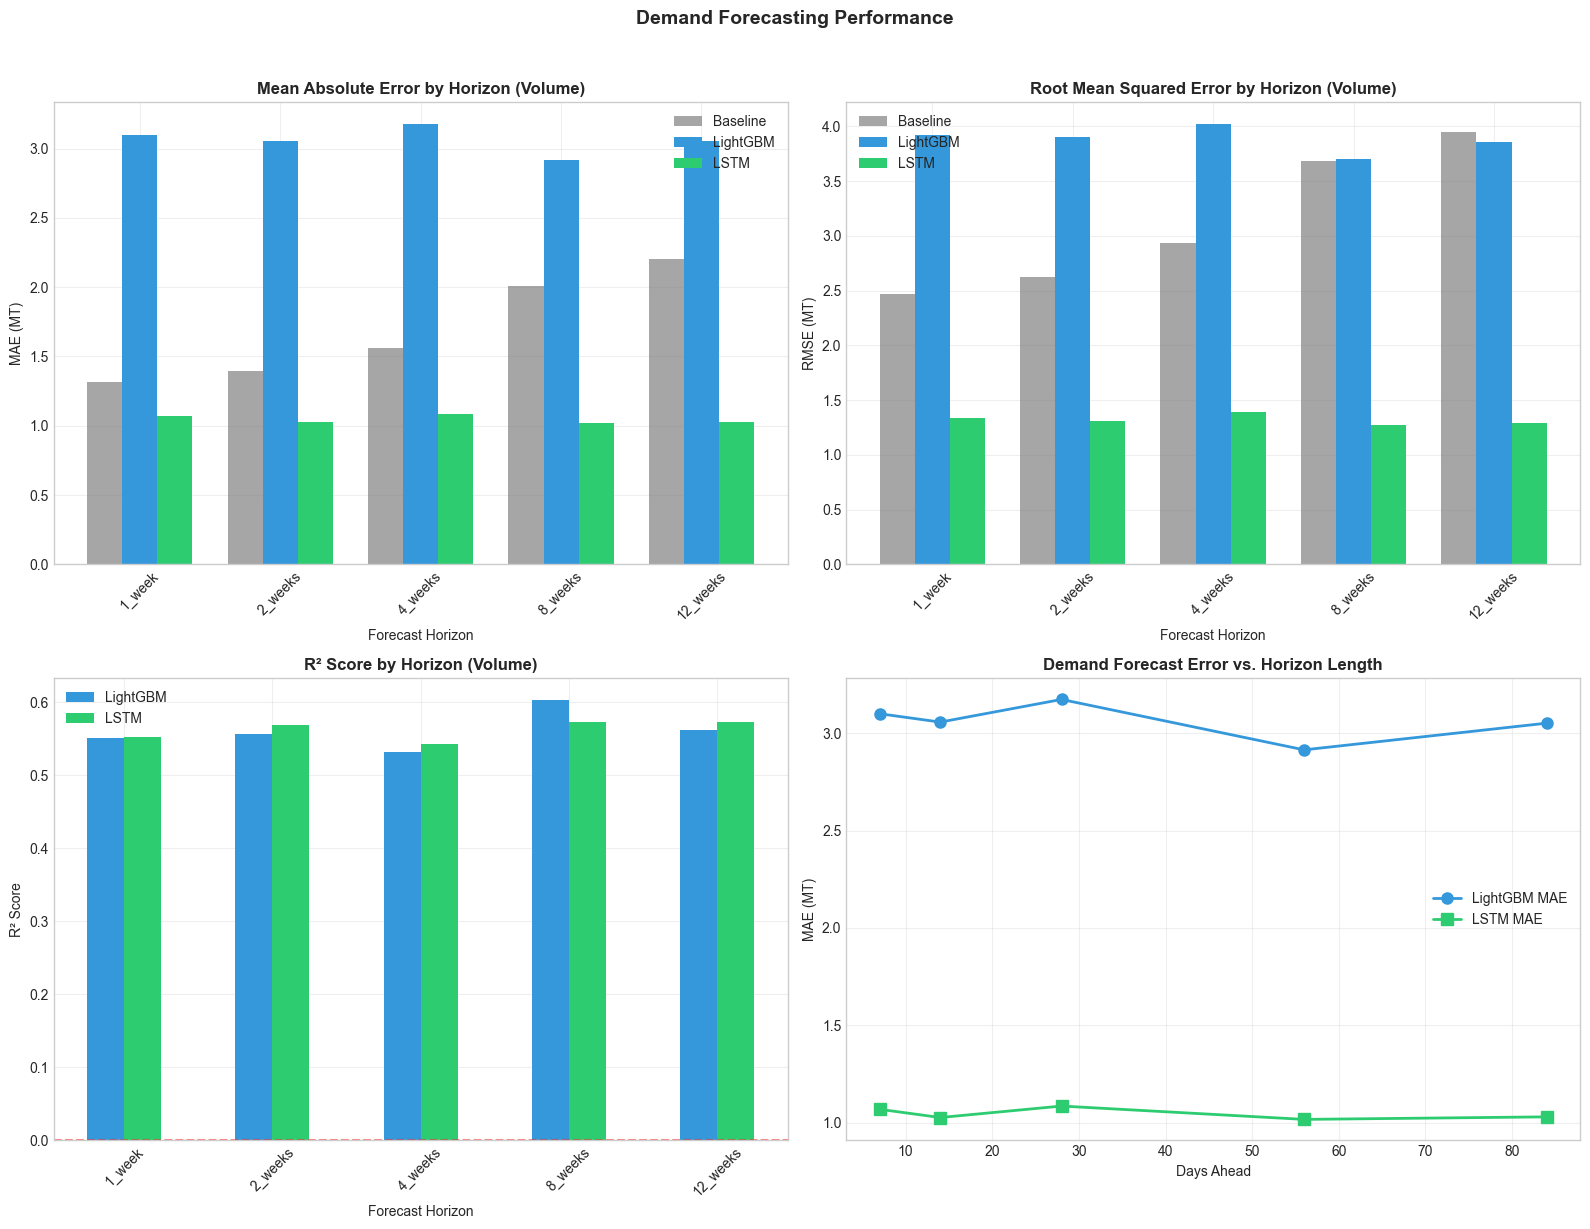

In [32]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

horizons_labels = list(HORIZONS.keys())
x = np.arange(len(horizons_labels))
width = 0.25

# 1. MAE Comparison
ax1 = axes[0, 0]
baseline_mae = [baseline_results.get(h, {}).get('MAE', 0) for h in HORIZONS.keys()]
lgb_mae = [lgb_results.get(h, {}).get('MAE', 0) for h in HORIZONS.keys()]
lstm_mae = []
for h in HORIZONS.keys():
    vals = [lstm_results[c][h]['MAE'] for c in lstm_results if h in lstm_results[c]]
    lstm_mae.append(np.mean(vals) if vals else 0)

ax1.bar(x - width, baseline_mae, width, label='Baseline', color='gray', alpha=0.7)
ax1.bar(x, lgb_mae, width, label='LightGBM', color='#3498db')
ax1.bar(x + width, lstm_mae, width, label='LSTM', color='#2ecc71')
ax1.set_xlabel('Forecast Horizon')
ax1.set_ylabel('MAE (MT)')
ax1.set_title('Mean Absolute Error by Horizon (Volume)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(horizons_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Comparison
ax2 = axes[0, 1]
baseline_rmse = [baseline_results.get(h, {}).get('RMSE', 0) for h in HORIZONS.keys()]
lgb_rmse = [lgb_results.get(h, {}).get('RMSE', 0) for h in HORIZONS.keys()]
lstm_rmse = []
for h in HORIZONS.keys():
    vals = [lstm_results[c][h]['RMSE'] for c in lstm_results if h in lstm_results[c]]
    lstm_rmse.append(np.mean(vals) if vals else 0)

ax2.bar(x - width, baseline_rmse, width, label='Baseline', color='gray', alpha=0.7)
ax2.bar(x, lgb_rmse, width, label='LightGBM', color='#3498db')
ax2.bar(x + width, lstm_rmse, width, label='LSTM', color='#2ecc71')
ax2.set_xlabel('Forecast Horizon')
ax2.set_ylabel('RMSE (MT)')
ax2.set_title('Root Mean Squared Error by Horizon (Volume)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(horizons_labels, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R² Score by Horizon
ax3 = axes[1, 0]
lgb_r2 = [lgb_results.get(h, {}).get('R2', 0) for h in HORIZONS.keys()]
lstm_r2 = []
for h in HORIZONS.keys():
    vals = [lstm_results[c][h]['R2'] for c in lstm_results if h in lstm_results[c]]
    lstm_r2.append(np.mean(vals) if vals else 0)

ax3.bar(x - width/2, lgb_r2, width, label='LightGBM', color='#3498db')
ax3.bar(x + width/2, lstm_r2, width, label='LSTM', color='#2ecc71')
ax3.set_xlabel('Forecast Horizon')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score by Horizon (Volume)', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(horizons_labels, rotation=45)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance Degradation
ax4 = axes[1, 1]
days_ahead = list(HORIZONS.values())
ax4.plot(days_ahead, lgb_mae, 'o-', label='LightGBM MAE', color='#3498db', linewidth=2, markersize=8)
ax4.plot(days_ahead, lstm_mae, 's-', label='LSTM MAE', color='#2ecc71', linewidth=2, markersize=8)
ax4.set_xlabel('Days Ahead')
ax4.set_ylabel('MAE (MT)')
ax4.set_title('Demand Forecast Error vs. Horizon Length', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Demand Forecasting Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Demand Patterns Analysis

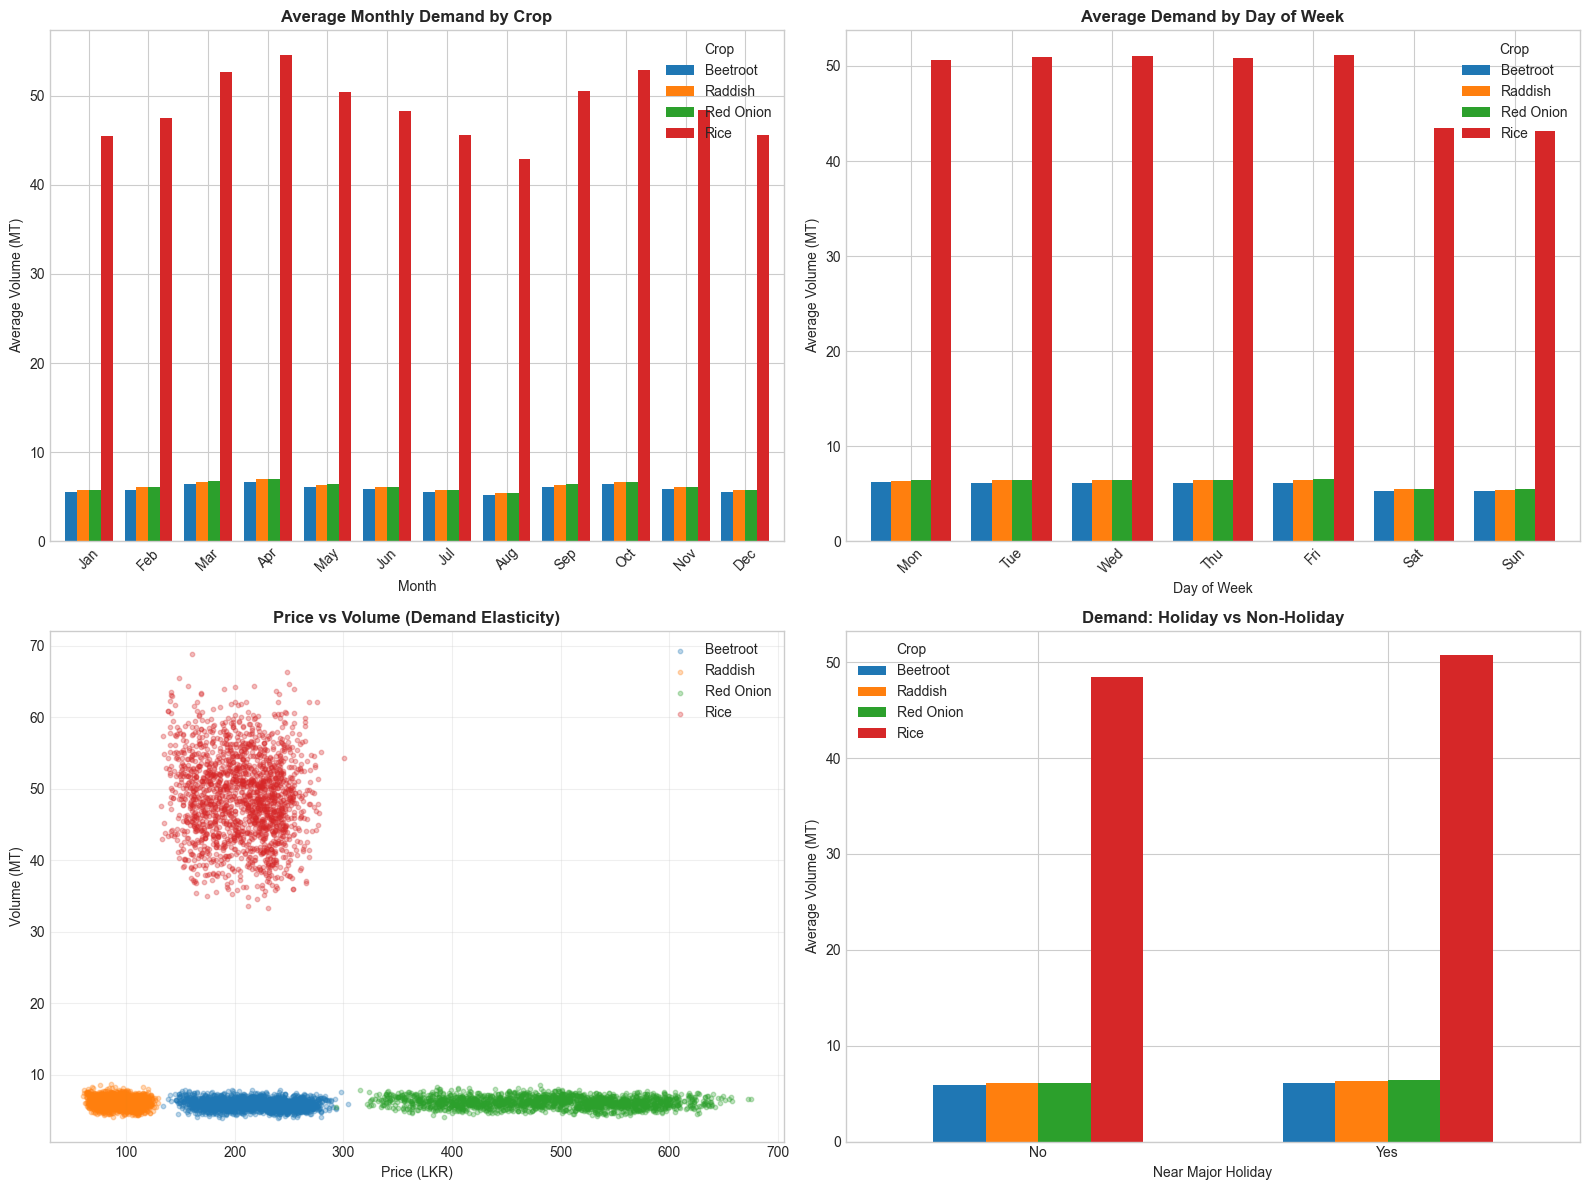

In [33]:
# Analyze demand patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Monthly demand pattern
ax1 = axes[0, 0]
monthly_demand = agg_df.groupby(['month', 'item'])['volume_MT'].mean().unstack()
monthly_demand.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Average Monthly Demand by Crop', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Volume (MT)')
ax1.legend(title='Crop')
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# 2. Day of week pattern
ax2 = axes[0, 1]
dow_demand = agg_df.groupby(['day_of_week', 'item'])['volume_MT'].mean().unstack()
dow_demand.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Average Demand by Day of Week', fontsize=12, fontweight='bold')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Volume (MT)')
ax2.legend(title='Crop')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

# 3. Price vs Volume scatter
ax3 = axes[1, 0]
for crop in agg_df['item'].unique():
    crop_data = agg_df[agg_df['item'] == crop]
    ax3.scatter(crop_data['price'], crop_data['volume_MT'], 
                label=crop, alpha=0.3, s=10)
ax3.set_title('Price vs Volume (Demand Elasticity)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Price (LKR)')
ax3.set_ylabel('Volume (MT)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Holiday effect on demand
ax4 = axes[1, 1]
holiday_demand = agg_df.groupby(['near_major_holiday', 'item'])['volume_MT'].mean().unstack()
holiday_demand.plot(kind='bar', ax=ax4, width=0.6)
ax4.set_title('Demand: Holiday vs Non-Holiday', fontsize=12, fontweight='bold')
ax4.set_xlabel('Near Major Holiday')
ax4.set_ylabel('Average Volume (MT)')
ax4.legend(title='Crop')
ax4.set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

---
## Save Models and Results

In [34]:
import joblib
import os

# Create directory for demand models
save_dir = '../models/saved_models/demand_forecasting'
os.makedirs(save_dir, exist_ok=True)

# Save LightGBM models
for horizon_name, model in lgb_models.items():
    model_path = f'{save_dir}/lgb_demand_{horizon_name}.txt'
    model.save_model(model_path)

# Save LSTM models
for crop, model in lstm_models.items():
    crop_name = crop.lower().replace(' ', '_')
    model_path = f'{save_dir}/lstm_demand_{crop_name}.keras'
    model.save(model_path)

# Save scalers
joblib.dump(lstm_scalers_X, f'{save_dir}/lstm_demand_scalers_X.joblib')
joblib.dump(lstm_scalers_y, f'{save_dir}/lstm_demand_scalers_y.joblib')
joblib.dump(le_item, f'{save_dir}/label_encoder_item.joblib')

# Save configuration
config = {
    'horizons': HORIZONS,
    'seq_length': SEQ_LENGTH,
    'lstm_features': lstm_features,
    'lgb_features': available_features,
    'crops': list(lstm_models.keys()),
    'target': 'volume_MT'
}
joblib.dump(config, f'{save_dir}/config.joblib')

# Save results summary
results_summary = {
    'baseline': baseline_results,
    'lightgbm': {k: {kk: vv for kk, vv in v.items() if kk not in ['y_test', 'y_pred']} 
                for k, v in lgb_results.items()},
    'lstm': {crop: {h: {kk: vv for kk, vv in metrics.items() if kk not in ['y_test', 'y_pred']}
                    for h, metrics in horizons.items()}
             for crop, horizons in lstm_results.items()}
}
joblib.dump(results_summary, f'{save_dir}/results_summary.joblib')


['../models/saved_models/demand_forecasting/results_summary.joblib']